# Zimbabwe PriorCVAE Decoder Samples

This notebook plots the marginal statistics and empirical covariance of the trained priorcvae decoder model.

In [1]:
import os
import yaml
import random

import numpyro
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import flax.linen as nn
from priorCVAE.priors import Matern52, SquaredExponential
from priorCVAE.datasets import GPDataset
from priorCVAE.models import MLPDecoder
from priorCVAE.utility import load_model_params
from experiments.zimbabwe_utility import read_data, plot_prior_samples, plot_statistics

import jax.config as config
config.update("jax_enable_x64", True)


## Loading setup

In [9]:
output_dir = "../../outputs/9fajdh64"
data_path = "../../data/zimbabwe/zwe2016phia.geojson"
n_samples = 1000
ls_to_plot = jnp.linspace(0.1, 4, 16)  # 16 is hardcoded as plotting on grid depends on it

kernel = Matern52()

In [10]:
cfg_path = os.path.join(output_dir, "files", "config.yaml")
with open(cfg_path, 'r') as file:
    cfg_data = yaml.safe_load(file)

conditional = cfg_data["conditional"]["value"]
latent_dim = cfg_data["latent_dim"]["value"]
normalize = cfg_data["normalize"]["value"]
dec_activation_fn = cfg_data["dec_activation"]["value"]["_target_"]
dec_activation_fn = getattr(nn, dec_activation_fn.split(".")[-1])

In [11]:
def get_vae_samples(decoder, trained_decoder_params, ls, conditional, n=1000):
    key = jax.random.PRNGKey(random.randint(0, 9999))
    rng, z_rng = jax.random.split(key, 2)
    z = jax.random.normal(z_rng, (n, latent_dim))
    if conditional:
        c = ls * jnp.ones((z.shape[0], 1))
        z = jnp.concatenate([z, c], axis=-1)
    vae_samples = decoder.apply({'params': trained_decoder_params}, z)
    
    return vae_samples

In [12]:
trained_decoder_params = load_model_params(os.path.join(output_dir, "model"))["decoder"]

In [13]:
output_dim = trained_decoder_params["dec_out"]["bias"].shape[0]
hidden_dim = trained_decoder_params["dec_hidden_0"]["bias"].shape[0]
decoder = MLPDecoder(hidden_dim=hidden_dim, out_dim=output_dim, activations=dec_activation_fn)

In [14]:
x, data = read_data(data_path, normalize=normalize)
data_generator = GPDataset(kernel=kernel, x=x, sample_lengthscale=False)

/Users/vermap1/projects/PriorCVAE_JAX/experiments/zimbabwe_utility.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data_frame["centroid"] = data_frame["geometry"].centroid
/Users/vermap1/projects/PriorCVAE_JAX/experiments/zimbabwe_utility.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  temp_centroids = data_frame["geometry"].centroid


## Plot marginals

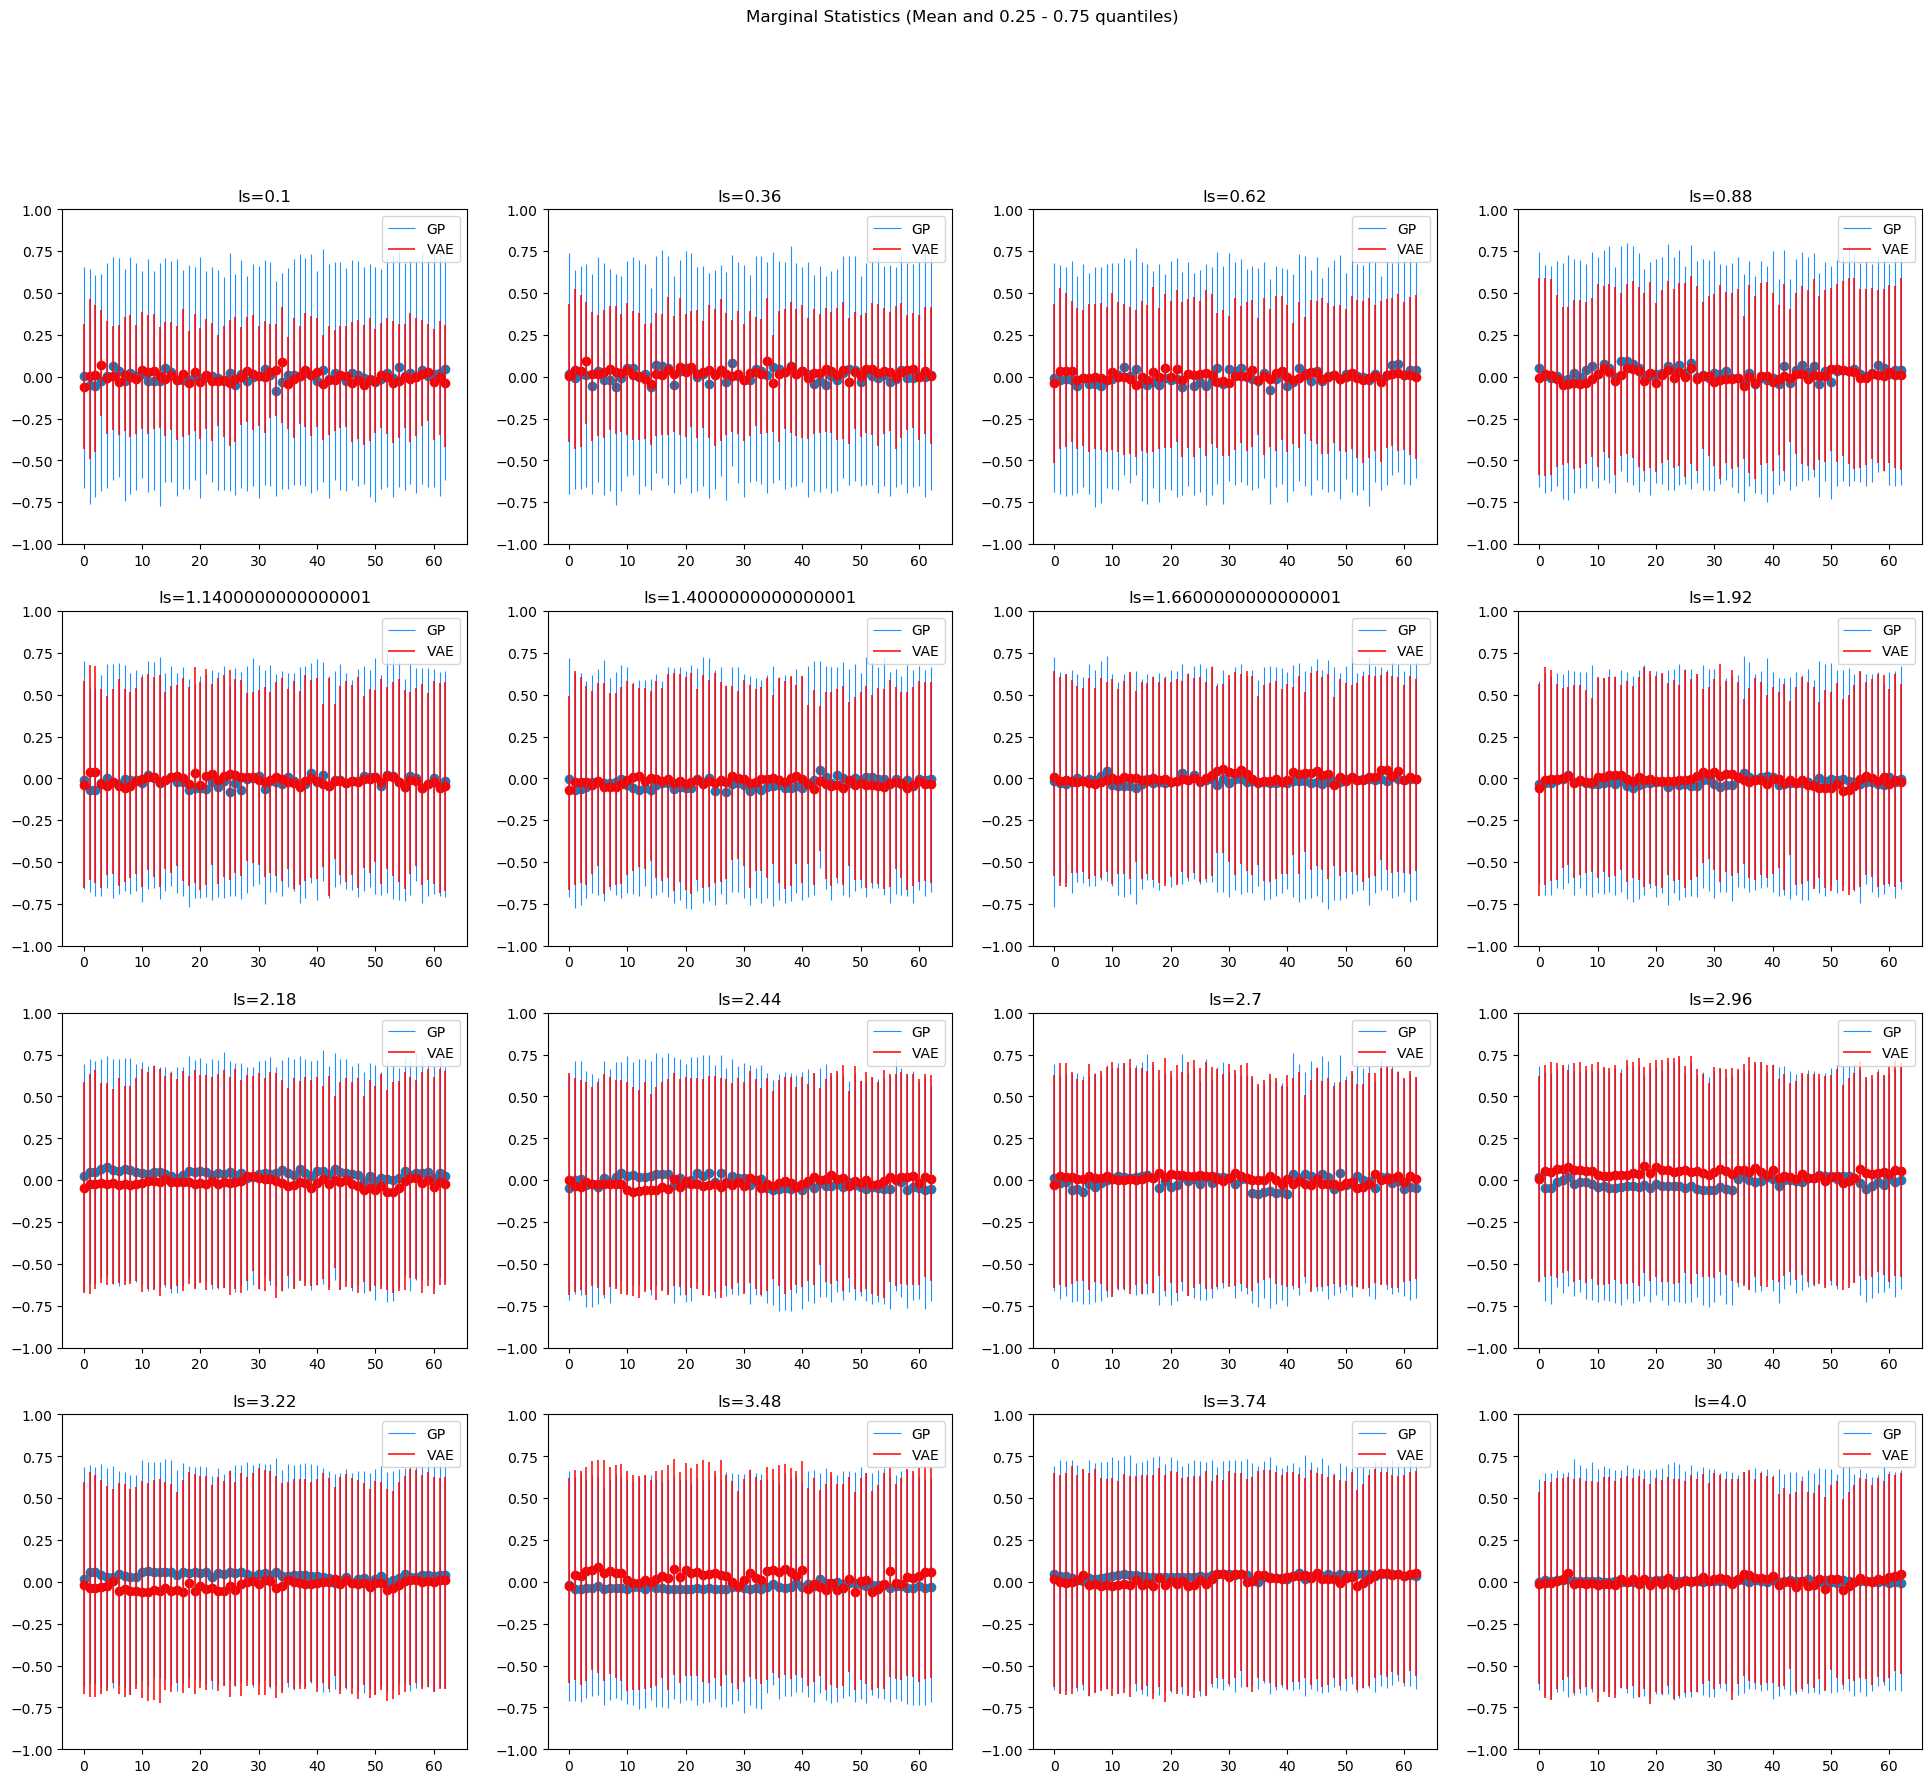

In [15]:
fig, axs = plt.subplots(4, 4, figsize=(24, 20))

for i in range(16):
    rows = int(i//4)
    cols = int(i%4)
    
    ls = ls_to_plot[i]
    data_generator.kernel.lengthscale = ls
    
    vae_samps = get_vae_samples(decoder, trained_decoder_params, ls, conditional, n=n_samples)
    _, prior_samples, _ = data_generator.simulatedata(n_samples=n_samples)
    
    gp_samples_mean = jnp.mean(prior_samples, axis=0)
    gp_draws_25, gp_draws_75 = jnp.quantile(prior_samples, jnp.array([.25, .75]), axis=0)

    vae_samples_mean = jnp.mean(vae_samps, axis=0)
    vae_draws_25, vae_draws_75 = jnp.quantile(vae_samps, jnp.array([.25, .75]), axis=0)

    axs[rows][cols].scatter(jnp.arange(len(gp_samples_mean)), gp_samples_mean)
    axs[rows][cols].scatter(jnp.arange(len(vae_samples_mean)), vae_samples_mean, color="red")

    axs[rows][cols].vlines(x=jnp.arange(len(gp_draws_25)),
               ymin=gp_draws_25,
               ymax=gp_draws_75,
               color="dodgerblue",
               label="GP",
               linewidth=0.8)

    axs[rows][cols].vlines(x=jnp.arange(len(vae_draws_25)),
               ymin=vae_draws_25,
               ymax=vae_draws_75,
               color="red",
               label="VAE",
               linewidth=1.1)
    axs[rows][cols].legend()
    axs[rows][cols].set_title(f"ls={round(ls, 2)}")
    axs[rows][cols].set_ylim([-1, 1])

plt.suptitle("Marginal Statistics (Mean and 0.25 - 0.75 quantiles)")
plt.show()

## Plot Cov

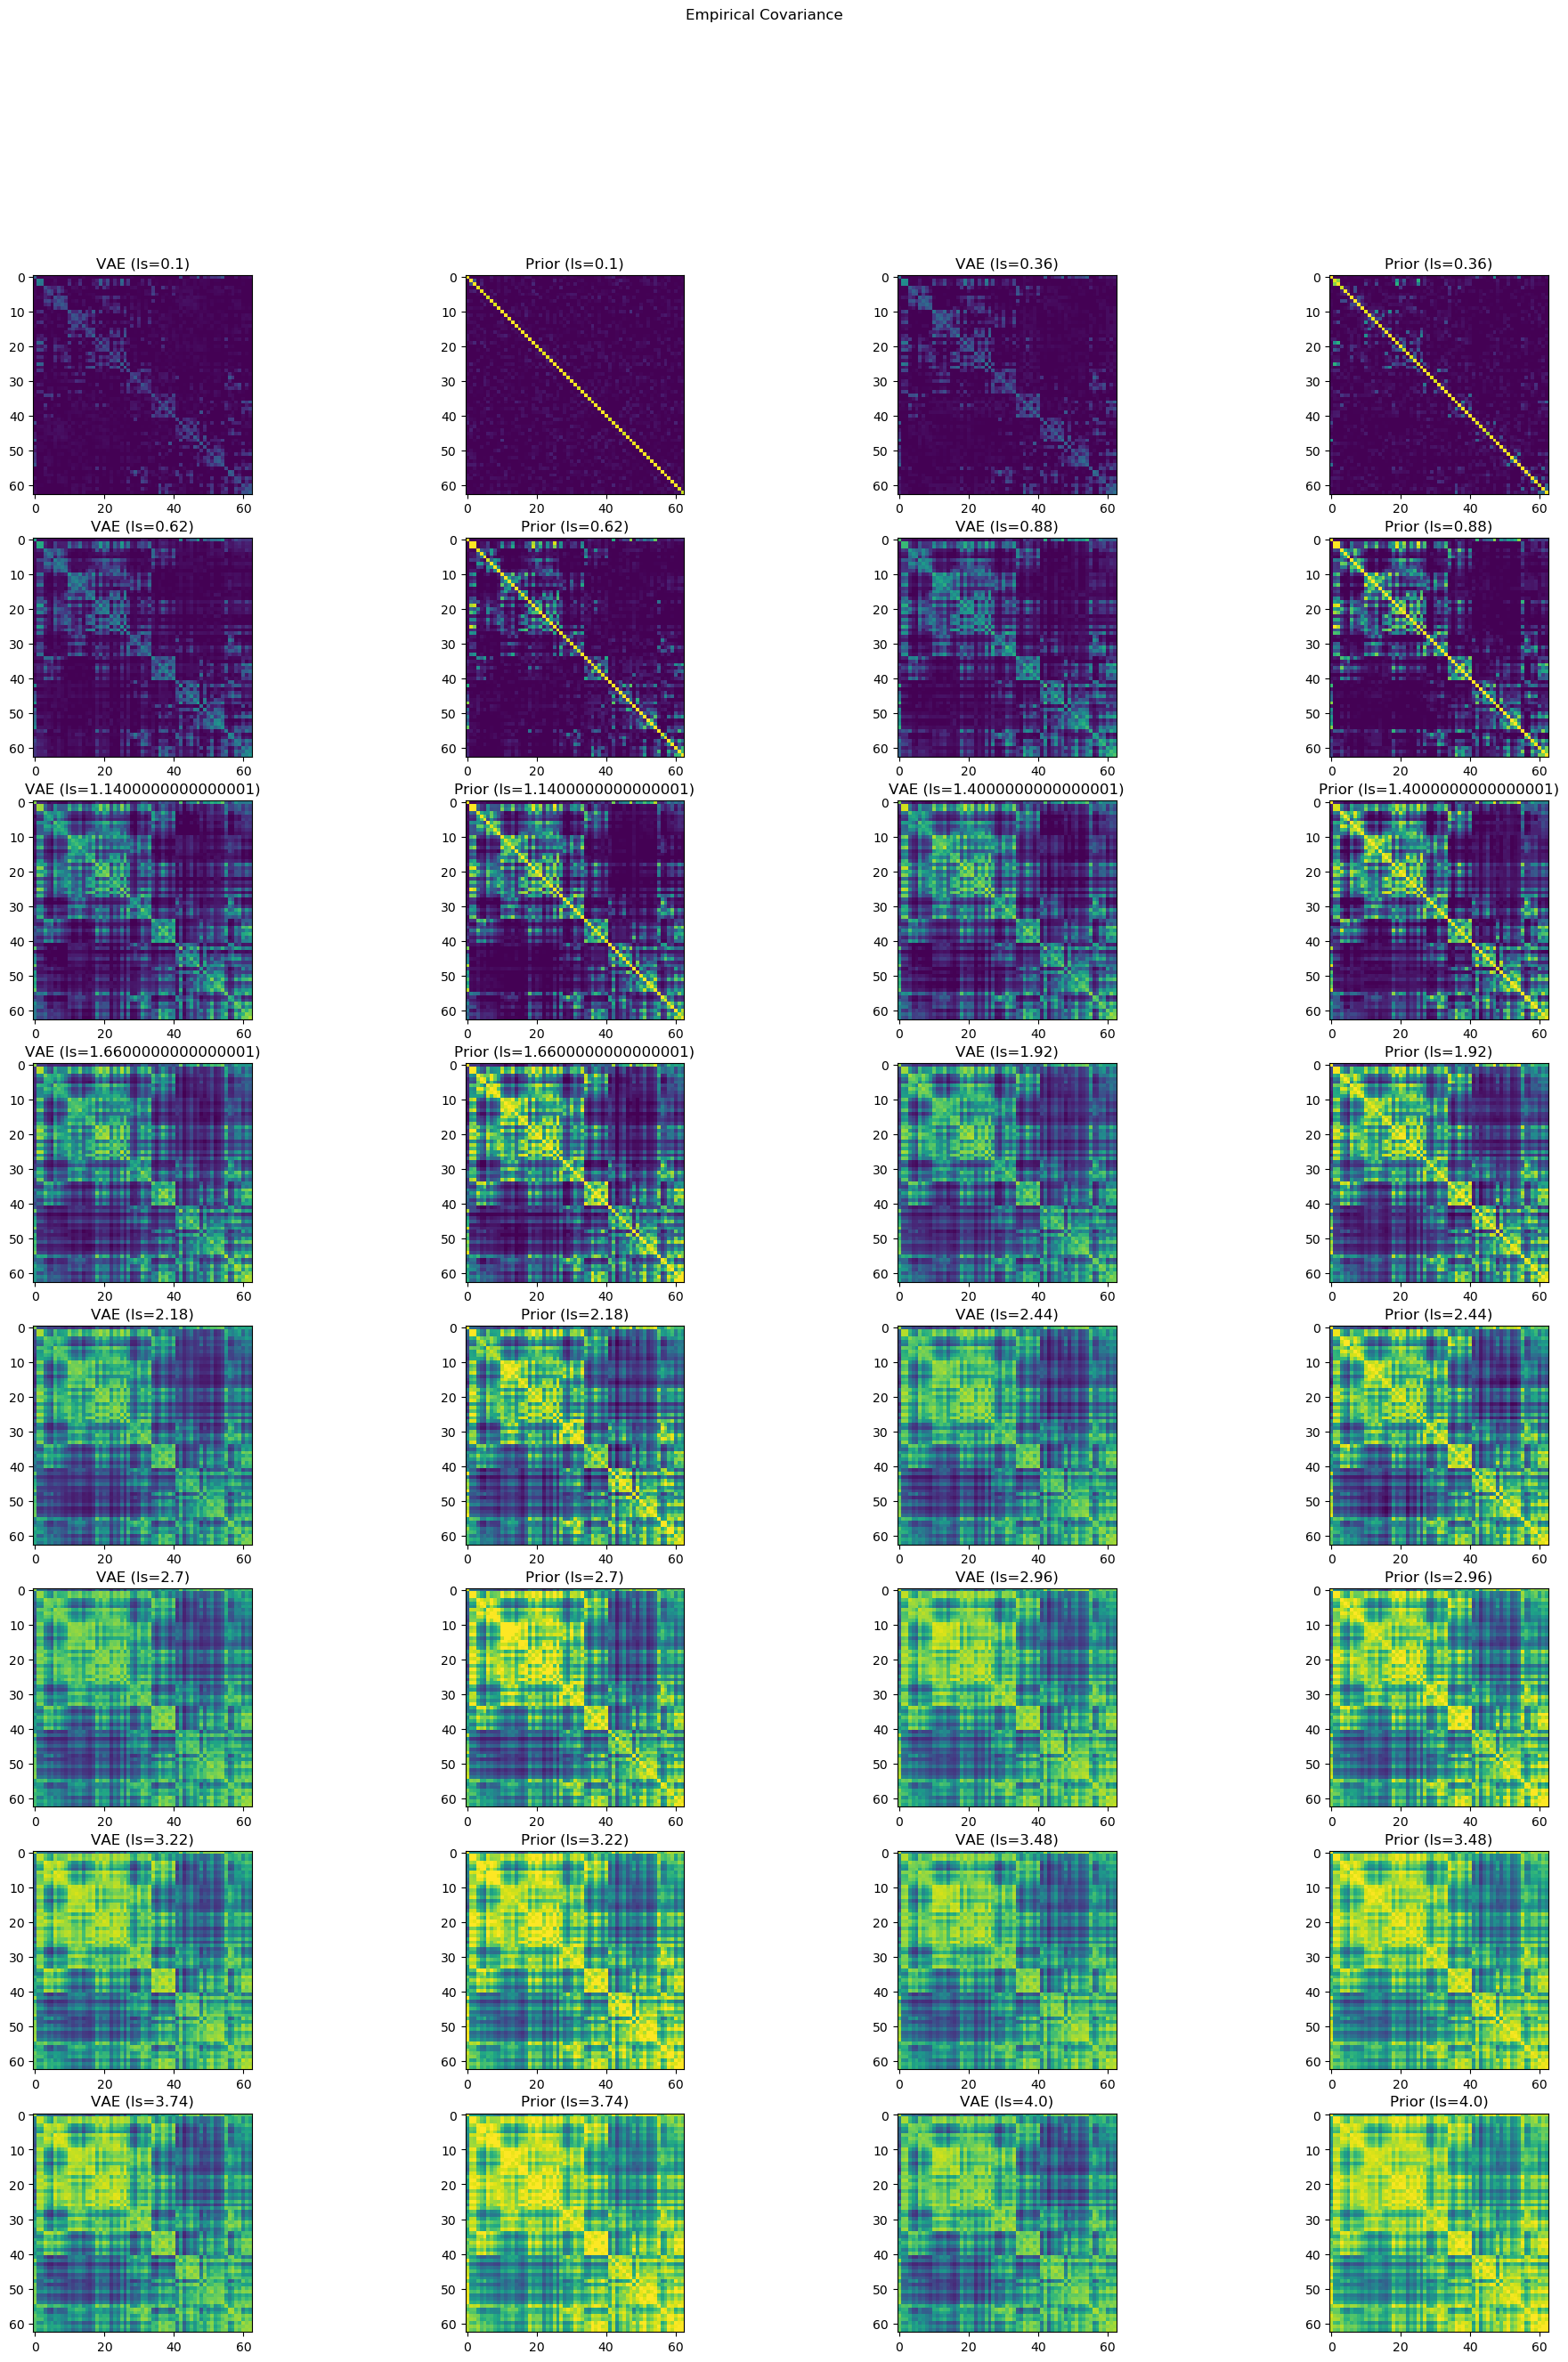

In [16]:
fig, axs = plt.subplots(8, 4, figsize=(24, 30))
cols = 2
for i in range(16):
    rows = int(i//2)
    cols = 0 if cols==2 else 2
    
    ls = ls_to_plot[i]
    data_generator.kernel.lengthscale = ls
    
    vae_samps = get_vae_samples(decoder, trained_decoder_params, ls, conditional, n=n_samples)
    _, prior_samples, _ = data_generator.simulatedata(n_samples=n_samples)
    
    vae_cov = jnp.cov(vae_samps.T)
    prior_cov = jnp.cov(prior_samples.T)
    
    ls = round(ls, 2)
    axs[rows][cols].imshow(vae_cov, vmin=0, vmax=1)
    axs[rows][cols].set_title(f"VAE (ls={ls})")
    axs[rows][cols + 1].imshow(prior_cov, vmin=0, vmax=1)
    axs[rows][cols + 1].set_title(f"Prior (ls={ls})")
    
plt.suptitle("Empirical Covariance")
plt.show()

## GP Samples

In [11]:
ls = .5

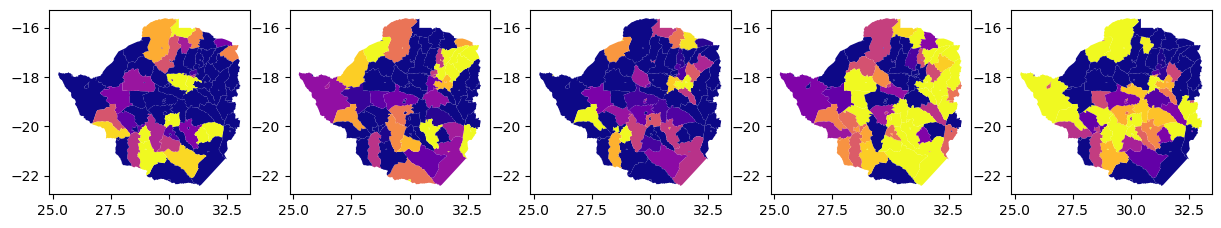

In [14]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
data_generator.kernel.lengthscale = ls
_, prior_samples, _ = data_generator.simulatedata(n_samples=10)

for i in range(5):
    data['gp' + str(i)] = prior_samples[i].reshape((-1, ))
    data.plot(column='gp' + str(i), ax=axs[i], cmap='plasma', vmin=0, vmax =1)
    
plt.show()

## PriorCVAE Samples

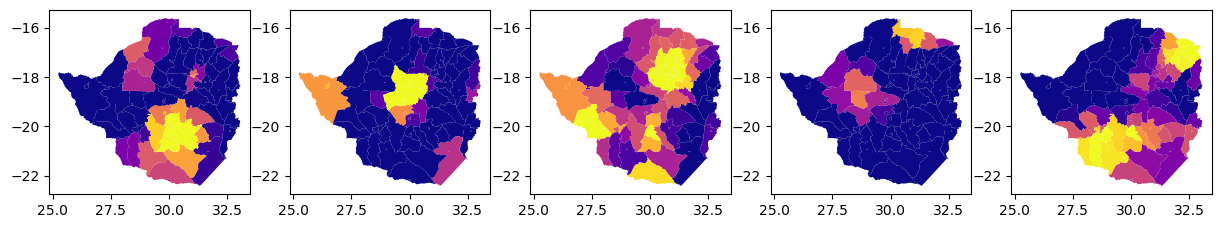

In [15]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
vae_samps = get_vae_samples(decoder, trained_decoder_params, ls, conditional, n=10)

for i in range(5):
    data['vae' + str(i)] = vae_samps[i].reshape((-1, ))
    data.plot(column='vae' + str(i), ax=axs[i], cmap='plasma', vmin=0, vmax =1)
    
plt.show()